
# work with example float output
# plot positions of floats at start
# Fig. 2 in GMD paper


In [1]:

import sys
sys.path.append('/global/homes/c/cnissen/scripts/seawater-3.3.4/seawater/')
import os
import glob
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import seawater
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import random
from numba import njit
from math import sin, cos, sqrt, atan2, radians


In [3]:
#-----
# saving plots
#-----

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/map_initial_positions/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    

In [4]:
####
# specifics for trajectory output
####

rad_to_deg = 180.0/np.pi
latlim = -45.0

path_mesh = '/global/cfs/cdirs/m4003/maltrud/'
meshID = 'EC30to60E2r2'
meshfile = xr. open_dataset(path_mesh+'ocean.'+meshID+'.210210.nc')
#print(meshfile)

lon  = meshfile['lonCell'].values*rad_to_deg
lat  = meshfile['latCell'].values*rad_to_deg
topo = meshfile['bottomDepth'].values
area = meshfile['areaCell'].values
zlevs            = meshfile['refBottomDepth'].values
layerThickness   = meshfile['layerThickness'].values
restingThickness = meshfile['restingThickness'].values

print(len(lon),'nodes in mesh')
print(topo.shape)
print(area.shape)
print('Min/Max lon:',np.min(lon),np.max(lon))
print('Min/Max lat:',np.min(lat),np.max(lat))
print('layerThickness.shape:',layerThickness.shape)
print('restingThickness.shape:',restingThickness.shape)

meshfile.close()



236853 nodes in mesh
(236853,)
(236853,)
Min/Max lon: 0.0007300572350528742 359.997672445938
Min/Max lat: -78.53259417674468 89.94461290099375
layerThickness.shape: (1, 236853, 60)
restingThickness.shape: (236853, 60)


In [5]:
#----
# daily
#----

float_freq = 'daily' # daily or 10daily
path = '/global/cfs/cdirs/m4003/maltrud/6year/floats/'

if float_freq in ['daily']:
    #file1 = 'floats.year0001.daily.nc'
    file1 = 'floats.year0055.nc'
    print('Load daily...',path+file1)
elif float_freq in ['10daily']:
    file1 = 'floats.year0001.10day.nc'
    print('Load 10-daily...',path+file1)
    
data = xr. open_dataset(path+file1)
#print(data)

lon_all   = data['particleColumnLon'].values*rad_to_deg #particleColumnLon
lat_all   = data['particleColumnLat'].values*rad_to_deg #particleColumnLat
depth_all = data['particleColumnDepth'].values #[:,0,:]
#ice_all   = data['particle_ifrac'].values 
dic_all   = data['particleColumnDIC'].values #[:,0,:]
#floatID   = data['particleColumnGlobalID'].values 
print('lat_all',lat_all.shape)

# set missing values to NaN (deep ocean layers) 
lat_all[dic_all==-1]=np.nan
lon_all[dic_all==-1]=np.nan
depth_all[dic_all==-1]=np.nan
dic_all[dic_all==-1]=np.nan

#print('Kick out floats in shallow regions...')
# kick out floats in shallow regions (these are not advected I think)
ind = np.where(zlevs<=2200)[0]
# those that are not advected have the same position for all time steps; filter by using the first time step
aux = np.sum(np.isnan(dic_all[0,ind,:]),axis=0) # check if any of the depth levels shallower than 1100m is NaN
ind_deep = np.where(aux==0)[0] # if it is, aux is >0; only keep those that are 0

print ('done')


Load daily... /global/cfs/cdirs/m4003/maltrud/6year/floats/floats.year0055.nc
lat_all (364, 60, 10560)
done


In [6]:
print (lat_all.shape,dic_all.shape,ind_deep.shape)

(364, 60, 10560) (364, 60, 10560) (8649,)


In [7]:
#---
# srf only, 1st day only or last day only
#---

lat_all_srf_day1 = lat_all[0,0,:]
lon_all_srf_day1 = lon_all[0,0,:]

lat_all_srf_day365 = lat_all[-1,0,:]
lon_all_srf_day365 = lon_all[-1,0,:]

print(lat_all_srf_day1.shape)


(10560,)


Plot initial float positions...


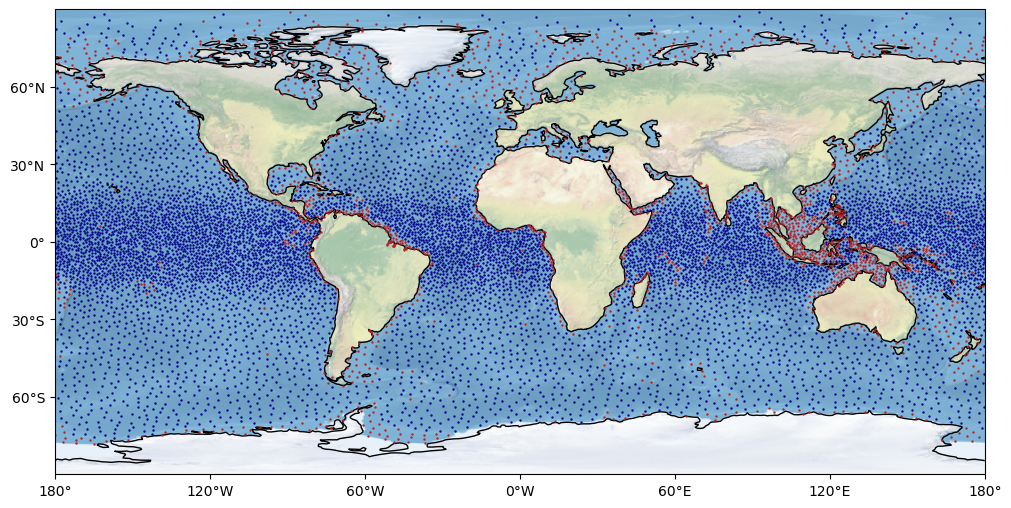

In [8]:
#----
# plot output from 1-year test run
#----

plot_first_day = True # if false, plot last day of 1-year test run
if plot_first_day:
    print('Plot initial float positions...')
else:
    print('Plot final float positions...')
    
    
ms = 0.7

fig = plt.figure(figsize=(12,25))
#  ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.set_extent([-179, 179, -90, 90])

count_deep = 0

for nn in range(0,lat_all_srf_day1.shape[0]):
    if nn in ind_deep:
        color1='darkblue'
        count_deep = count_deep+1
    else:
        color1='firebrick'
    if plot_first_day:
        ny_lon, ny_lat = lon_all_srf_day1[nn],lat_all_srf_day1[nn]
    else:
        ny_lon, ny_lat = lon_all_srf_day365[nn],lat_all_srf_day365[nn]
    
    plt.plot(ny_lon, ny_lat,
             color=color1, marker='o',markersize=ms,transform=ccrs.Geodetic(),
             )
    del ny_lon,ny_lat
    
ax.yaxis.tick_left()
ax.set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
#                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

save_plots = False
if save_plots:
    dpicnt = 200
    if plot_first_day:
        #filename = 'Map_test_run_initial_float_positions.png'
        filename = 'Map_run_6years_initial_float_positions.png'
    else: # plot last day
        #filename = 'Map_test_run_final_float_positions.png'
        filename = 'Map_run_6years_final_float_positions.png'
    
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()


In [9]:

print('Total number of floats:',lat_all_srf_day1.shape[0])
print('Total number of floats in deep areas:',count_deep)
print('Total number of floats in shallow areas:',lat_all_srf_day1.shape[0]-count_deep)



Total number of floats: 10560
Total number of floats in deep areas: 8649
Total number of floats in shallow areas: 1911


Plot initial float positions...


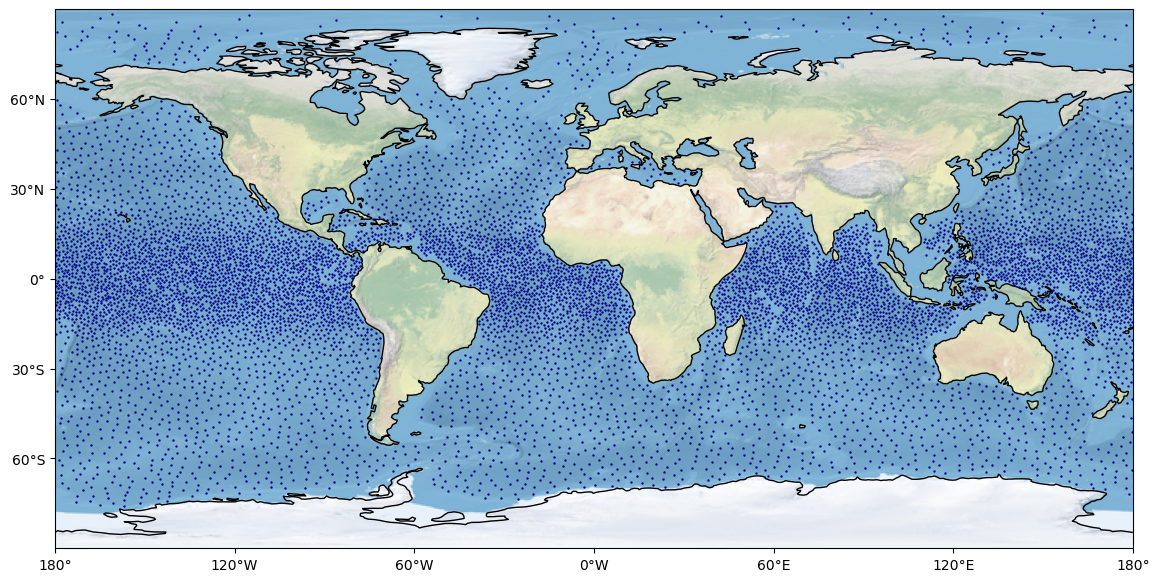

In [10]:
#----
# plot output from 1-year test run
#----

plot_first_day = True # if false, plot last day of 1-year test run
if plot_first_day:
    print('Plot initial float positions...')
else:
    print('Plot final float positions...')
    
fig = plt.figure(figsize=(18,7)) # x, y
#  ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.set_extent([-179, 179, -90, 90])

count_deep = 0

for nn in range(0,lat_all_srf_day1.shape[0]):
    if nn in ind_deep:
        color1='darkblue'
        count_deep = count_deep+1
        if plot_first_day:
            ny_lon, ny_lat = lon_all_srf_day1[nn],lat_all_srf_day1[nn]
        else:
            ny_lon, ny_lat = lon_all_srf_day365[nn],lat_all_srf_day365[nn]

        plt.plot(ny_lon, ny_lat,
                 color=color1, marker='o',markersize=ms,transform=ccrs.Geodetic(),
                 )
        del ny_lon,ny_lat
    
ax.yaxis.tick_left()
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                  linewidth=0.1, color='gray', alpha=0.5, linestyle='None')
#gl.xlabel_style = {'size': 12, 'color': 'k'}
#gl.ylabel_style = {'color': 'red', 'weight': 'bold', 'size':12}
#gl.top_labels = False
#gl.left_labels = False

ax.set_xticks([-180,-120, -60, 0, 60, 120, 180],crs=ccrs.PlateCarree())
ax.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
#ax.xaxis.label.set_color('red')
#ax.yaxis.label.set_color('red')
    
save_plots = False
if save_plots:
    dpicnt = 200
    if plot_first_day:
        #filename = 'Map_test_run_initial_float_positions.png'
        filename = 'Map_run_6years_initial_float_positions_only_deepOcean.png'
    else: # plot last day
        #filename = 'Map_test_run_final_float_positions.png'
        filename = 'Map_run_6years_final_float_positions_only_deepOcean.png'
    
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()


In [11]:
#---
# get number of floats per latitude
#---
# later: do the same for all Argo and all SOCCOM floats

print(lat_all_srf_day1.shape)

lat_bins = np.arange(-90,90+1,1)

ind_bin = np.digitize(lat_all_srf_day1,lat_bins)
print(np.min(ind_bin),np.max(ind_bin))

num_floats_per_lat_bin = np.zeros(len(lat_bins))
for ii in range(0,len(lat_bins)):
    ind = np.where(ind_bin==ii+1)[0] # check if there should be a "+1" here or not
    if len(ind)>0:
        num_floats_per_lat_bin[ii] = ind.shape[0]
    else:
        print('No floats for latitutde',ii,lat_bins[ii])
    del ind



(10560,)
12 179
No floats for latitutde 0 -90
No floats for latitutde 1 -89
No floats for latitutde 2 -88
No floats for latitutde 3 -87
No floats for latitutde 4 -86
No floats for latitutde 5 -85
No floats for latitutde 6 -84
No floats for latitutde 7 -83
No floats for latitutde 8 -82
No floats for latitutde 9 -81
No floats for latitutde 10 -80
No floats for latitutde 179 89
No floats for latitutde 180 90


In [12]:
#---
# get number of floats per longitude
#---
# later: do the same for all Argo and all SOCCOM floats

print(lat_all_srf_day1.shape)

lon_bins = np.arange(-180,180+1,1)

# convert from 0:360 to -179:179
lon_all_srf_day1_transf = np.copy(lon_all_srf_day1)
lon_all_srf_day1_transf[lon_all_srf_day1_transf>180] = lon_all_srf_day1_transf[lon_all_srf_day1_transf>180]-360
print ('Min/Max lon:',np.min(lon_all_srf_day1_transf),np.max(lon_all_srf_day1_transf))

ind_bin = np.digitize(lon_all_srf_day1_transf,lon_bins)
print(np.min(ind_bin),np.max(ind_bin))

num_floats_per_lon_bin = np.zeros(len(lon_bins))
for ii in range(0,len(lon_bins)):
    ind = np.where(ind_bin==ii+1)[0] # check if there should be a "+1" here or not
    if len(ind)>0:
        num_floats_per_lon_bin[ii] = ind.shape[0]
    else:
        print('No floats for longitude',ii,lon_bins[ii])
    del ind



(10560,)
Min/Max lon: -179.89500132312224 179.9832710454898
1 360
No floats for longitude 360 180


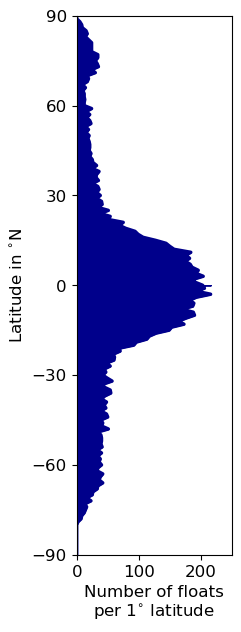

In [13]:
#---
# plot: num floats per latitude
#---
lw = 2.5
fs = 12

color1 = 'darkblue'

fig = plt.figure(figsize=(2,7))
plt.plot(num_floats_per_lat_bin,lat_bins,color=color1,linewidth=lw)
plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
plt.xlabel('Number of floats\nper 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((0,250))
plt.xticks(fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],fontsize=fs)

plt.fill_between(
        x= num_floats_per_lat_bin, 
        y1= lat_bins, 
        where= (0 <= num_floats_per_lat_bin)&(num_floats_per_lat_bin <= 250),
        color= color1,
        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    if plot_first_day:
        filename = 'Floats_per_latitude_initial_float_positions.png'
    else: # plot last day
        filename = 'Floats_per_latitude_final_float_positions.png'
    
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
    
plt.show()



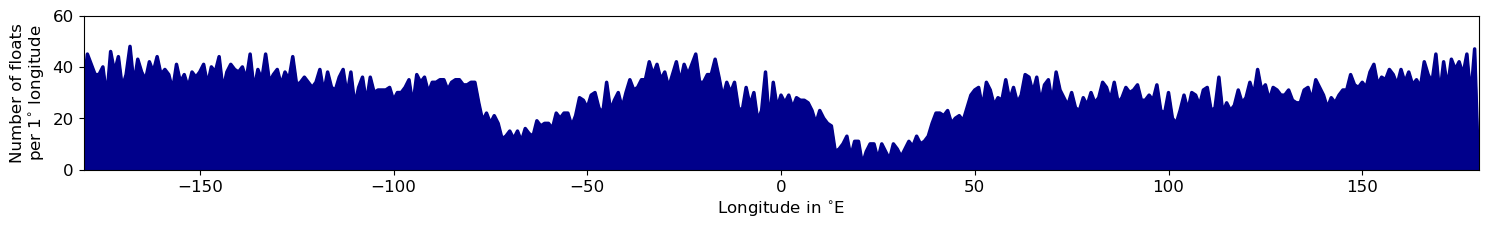

In [14]:
#---
# plot: num floats per longitude
#---
lw = 2.5
fs = 12
color1='darkblue'

fig = plt.figure(figsize=(18,2))
plt.plot(lon_bins,num_floats_per_lon_bin,color=color1,linewidth=lw)
plt.xlabel('Longitude in $^{\circ}$E',fontsize=fs)
plt.ylabel('Number of floats\nper 1$^{\circ}$ longitude',fontsize=fs)
plt.ylim((0,60))
plt.xlim((-180,180))
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.fill_between(
        x= lon_bins, 
        y1= num_floats_per_lon_bin, 
        where= (-180 <= lon_bins)&(lon_bins <= 180),
        color= color1,
        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    if plot_first_day:
        filename = 'Floats_per_longitude_initial_float_positions.png'
    else: # plot last day
        filename = 'Floats_per_longitude_final_float_positions.png'
    
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
    
plt.show()



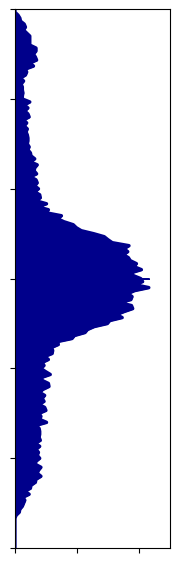

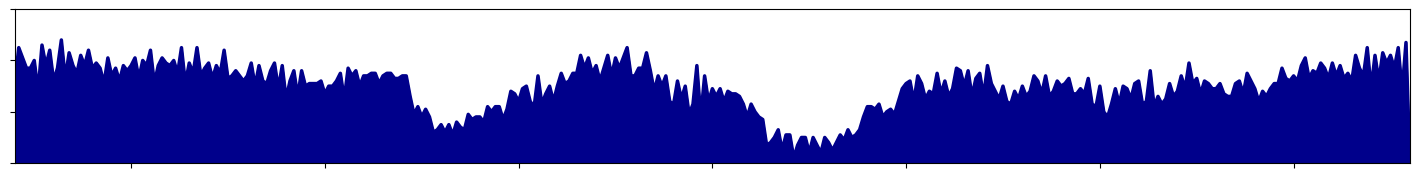

In [15]:
#----
# EPS
#----
#---
# plot: num floats per latitude
#---
lw = 2.5
fs = 12

color1 = 'darkblue'

fig = plt.figure(figsize=(2,7))
plt.plot(num_floats_per_lat_bin,lat_bins,color=color1,linewidth=lw)
#plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
#plt.xlabel('Number of floats\nper 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((0,250))
plt.xticks([0,100,200],[],fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],[],fontsize=fs)

plt.fill_between(
        x= num_floats_per_lat_bin, 
        y1= lat_bins, 
        where= (0 <= num_floats_per_lat_bin)&(num_floats_per_lat_bin <= 250),
        color= color1,
        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    if plot_first_day:
        filename = 'Floats_per_latitude_initial_float_positions.eps'
    else: # plot last day
        filename = 'Floats_per_latitude_final_float_positions.eps'
    
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    
plt.show()


#---
# plot: num floats per longitude
#---
lw = 2.5
fs = 12
color1='darkblue'

fig = plt.figure(figsize=(18,2))
plt.plot(lon_bins,num_floats_per_lon_bin,color=color1,linewidth=lw)
#plt.xlabel('Longitude in $^{\circ}$E',fontsize=fs)
#plt.ylabel('Number of floats\nper 1$^{\circ}$ longitude',fontsize=fs)
plt.ylim((0,60))
plt.xlim((-180,180))
plt.xticks([-150,-100,-50,0,50,100,150],[],fontsize=fs)
plt.yticks([0,20,40,60],[],fontsize=fs)

plt.fill_between(
        x= lon_bins, 
        y1= num_floats_per_lon_bin, 
        where= (-180 <= lon_bins)&(lon_bins <= 180),
        color= color1,
        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    if plot_first_day:
        filename = 'Floats_per_longitude_initial_float_positions.eps'
    else: # plot last day
        filename = 'Floats_per_longitude_final_float_positions.eps'
    
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    
    
plt.show()



In [17]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/map_initial_positions/


In [18]:
#----
# get real-world float data: get position of first complete cycle
#----
# txt files were created using argopy
# https://www.theoj.org/joss-papers/joss.02425/10.21105.joss.02425.pdf

path1 = '/pscratch/sd/c/cnissen/ARGO_floats/txt_files/'
year1,year2 = 2012,2017 #2019
years_all = np.arange(year1,year2+1,1)

lat_float = []
lon_float = []
for yy in range(0,len(years_all)):
    print('Year ',years_all[yy])
    file1 = 'Argo_floats_latitude_first_cycle_year_'+str(years_all[yy])+'.txt'
    file2 = 'Argo_floats_longitude_first_cycle_year_'+str(years_all[yy])+'.txt'
    with open(path1+file1) as f:
        for line in f:
            lat_float.append(float(line.strip('\n')))
    with open(path1+file2) as f:
        for line in f:
            lon_float.append(float(line.strip('\n')))
    del file1,file2
            
print('done')

print(len(lat_float))
print(len(lon_float))


Year  2012
Year  2013
Year  2014
Year  2015
Year  2016
Year  2017
done
5086
5086


In [19]:
#---
# ARGO FLOATS: get number of floats per latitude
#---

print(len(lat_float))

lat_bins = np.arange(-90,90+1,1)

ind_bin = np.digitize(lat_float,lat_bins)
print(np.min(ind_bin),np.max(ind_bin))

num_floats_per_lat_bin_ARGO = np.zeros(len(lat_bins))
for ii in range(0,len(lat_bins)):
    ind = np.where(ind_bin==ii+1)[0] # check if there should be a "+1" here or not
    if len(ind)>0:
        num_floats_per_lat_bin_ARGO[ii] = ind.shape[0]
    else:
        print('No floats for latitutde',ii,lat_bins[ii])
    del ind


    

5086
13 168
No floats for latitutde 0 -90
No floats for latitutde 1 -89
No floats for latitutde 2 -88
No floats for latitutde 3 -87
No floats for latitutde 4 -86
No floats for latitutde 5 -85
No floats for latitutde 6 -84
No floats for latitutde 7 -83
No floats for latitutde 8 -82
No floats for latitutde 9 -81
No floats for latitutde 10 -80
No floats for latitutde 11 -79
No floats for latitutde 16 -74
No floats for latitutde 168 78
No floats for latitutde 169 79
No floats for latitutde 170 80
No floats for latitutde 171 81
No floats for latitutde 172 82
No floats for latitutde 173 83
No floats for latitutde 174 84
No floats for latitutde 175 85
No floats for latitutde 176 86
No floats for latitutde 177 87
No floats for latitutde 178 88
No floats for latitutde 179 89
No floats for latitutde 180 90


In [20]:
#---
# get number of floats per longitude
#---

print(len(lon_float))

lon_bins = np.arange(-180,180+1,1)

#lon_all_srf_day1_transf = np.copy(lon_all_srf_day1)
#lon_all_srf_day1_transf[lon_all_srf_day1_transf>180] = lon_all_srf_day1_transf[lon_all_srf_day1_transf>180]-360
print ('Min/Max lon:',np.min(lon_float),np.max(lon_float))

ind_bin = np.digitize(lon_float,lon_bins)
print(np.min(ind_bin),np.max(ind_bin))

num_floats_per_lon_bin_ARGO = np.zeros(len(lon_bins))
for ii in range(0,len(lon_bins)):
    ind = np.where(ind_bin==ii+1)[0] # check if there should be a "+1" here or not
    if len(ind)>0:
        num_floats_per_lon_bin_ARGO[ii] = ind.shape[0]
    else:
        print('No floats for longitude',ii,lon_bins[ii])
    del ind



5086
Min/Max lon: -179.998 179.99773
1 360
No floats for longitude 224 44
No floats for longitude 360 180


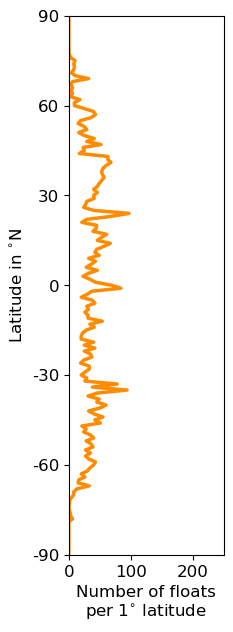

In [21]:
#---
# plot: num floats per latitude for ARGO
#---
lw = 2.5
fs = 12

color1 = 'darkorange'

fig = plt.figure(figsize=(2,7))
plt.plot(num_floats_per_lat_bin_ARGO,lat_bins,color=color1,linewidth=lw)
plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
plt.xlabel('Number of floats\nper 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((0,250))
plt.xticks(fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],[-90,-60,-30,0,30,60,90],fontsize=fs)

#plt.fill_between(
#        x= num_floats_per_lat_bin_ARGO, 
#        y1= lat_bins, 
#        where= (0 <= num_floats_per_lat_bin_ARGO)&(num_floats_per_lat_bin_ARGO <= 250),
#        color= color1,
#        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Floats_per_latitude_initial_float_positions_ARGO_2012_2017.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
    
plt.show()



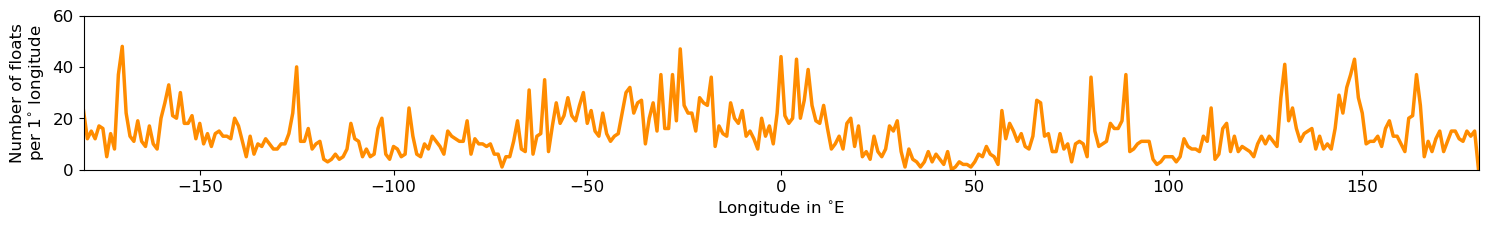

In [22]:
#---
# plot: num floats per longitude for ARGO
#---
lw = 2.5
fs = 12
color1='darkorange'

fig = plt.figure(figsize=(18,2))
plt.plot(lon_bins,num_floats_per_lon_bin_ARGO,color=color1,linewidth=lw)
plt.xlabel('Longitude in $^{\circ}$E',fontsize=fs)
plt.ylabel('Number of floats\nper 1$^{\circ}$ longitude',fontsize=fs)
plt.ylim((0,60))
plt.xlim((-180,180))
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

#plt.fill_between(
#        x= lon_bins, 
#        y1= num_floats_per_lon_bin_ARGO, 
#        where= (-180 <= lon_bins)&(lon_bins <= 180),
#        color= color1,
#        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Floats_per_longitude_initial_float_positions_ARGO_2012_2017.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
    
plt.show()



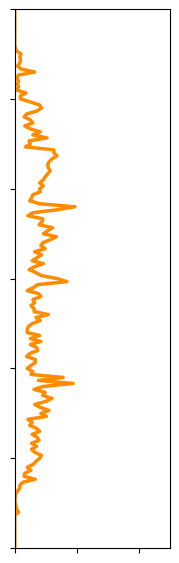

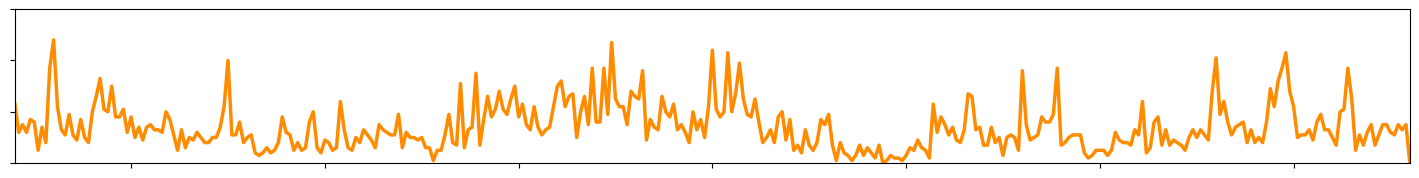

In [23]:
#---
# EPS
# plot: num floats per latitude for ARGO
#---
lw = 2.5
fs = 12

color1 = 'darkorange'

fig = plt.figure(figsize=(2,7))
plt.plot(num_floats_per_lat_bin_ARGO,lat_bins,color=color1,linewidth=lw)
#plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
#plt.xlabel('Number of floats\nper 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((0,250))
plt.xticks([0,100,200],[],fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],[],fontsize=fs)

#plt.fill_between(
#        x= num_floats_per_lat_bin_ARGO, 
#        y1= lat_bins, 
#        where= (0 <= num_floats_per_lat_bin_ARGO)&(num_floats_per_lat_bin_ARGO <= 250),
#        color= color1,
#        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Floats_per_latitude_initial_float_positions_ARGO_2012_2017.eps'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    
    
plt.show()




#---
# plot: num floats per longitude for ARGO
#---
lw = 2.5
fs = 12
color1='darkorange'

fig = plt.figure(figsize=(18,2))
plt.plot(lon_bins,num_floats_per_lon_bin_ARGO,color=color1,linewidth=lw)
#plt.xlabel('Longitude in $^{\circ}$E',fontsize=fs)
#plt.ylabel('Number of floats\nper 1$^{\circ}$ longitude',fontsize=fs)
plt.ylim((0,60))
plt.xlim((-180,180))
plt.xticks([-150,-100,-50,0,50,100,150],[],fontsize=fs)
plt.yticks([0,20,40,60],[],fontsize=fs)

#plt.fill_between(
#        x= lon_bins, 
#        y1= num_floats_per_lon_bin_ARGO, 
#        where= (-180 <= lon_bins)&(lon_bins <= 180),
#        color= color1,
#        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Floats_per_longitude_initial_float_positions_ARGO_2012_2017.eps'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    
    
plt.show()




In [26]:
#---
# get all SOCCOM
#---

path_soccom = '/global/cfs/cdirs/m4003/cnissen/SOCCOM_data/download_snapshot_Dec2022/SOCCOM_GO-BGC_LoResQC_LIAR_21Dec2022_netcdf/'

# get list of netcdf files
list_nc = glob.glob(path_soccom+"*.nc")
print(len(list_nc),'files are processed')

# initialize arrays
lat_soccom = []
lon_soccom = []
for nn in range(0,len(list_nc)):
    f1 = xr.open_dataset(list_nc[nn])
    lat_aux   = f1['Lat'].values
    lon_aux   = f1['Lon'].values
    time = f1['mon_day_yr'].values 
    f1.close()
    
    if int(str(time[0])[8:12])<=2017: # RESTRICT TO FLOATS DEPLOYED UNTIL 2017 or so
        # append position of first cycle to array
        # if first position is NaN, test second one
        if ~np.isnan(lat_aux[0]):
            lat_soccom  = np.hstack((lat_soccom,lat_aux[0]))
            lon_soccom  = np.hstack((lon_soccom,lon_aux[0]))
        else:
            if ~np.isnan(lat_aux[1]):
                lat_soccom  = np.hstack((lat_soccom,lat_aux[1]))
                lon_soccom  = np.hstack((lon_soccom,lon_aux[1]))
            else:
                lat_soccom  = np.hstack((lat_soccom,lat_aux[2]))
                lon_soccom  = np.hstack((lon_soccom,lon_aux[2]))
    
    del lat_aux,lon_aux, time

print(lat_soccom.shape,lon_soccom.shape)
#print(int(str(time[0])[8:12]))


394 files are processed
(158,) (158,)


In [27]:
#---
# SOCCOM FLOATS: get number of floats per latitude
#---

print(len(lat_float))

lat_bins = np.arange(-90,90+1,1)

ind_bin = np.digitize(lat_soccom,lat_bins)
print(np.min(ind_bin),np.max(ind_bin))

num_floats_per_lat_bin_SOCCOM = np.zeros(len(lat_bins))
for ii in range(0,len(lat_bins)):
    ind = np.where(ind_bin==ii+1)[0] # check if there should be a "+1" here or not
    if len(ind)>0:
        num_floats_per_lat_bin_SOCCOM[ii] = ind.shape[0]
    #else:
        #print('No floats for latitutde',ii,lat_bins[ii])
    del ind


#---
# SOCCOM FLOATS: get number of floats per longitude
#---

print(len(lon_float))

lon_bins = np.arange(-180,180+1,1)

lon_soccom_transf = np.copy(lon_soccom)
lon_soccom_transf[lon_soccom_transf>180] = lon_soccom_transf[lon_soccom_transf>180]-360
print ('Min/Max lon:',np.min(lon_soccom_transf),np.max(lon_soccom_transf))

ind_bin = np.digitize(lon_soccom_transf,lon_bins)
print(np.min(ind_bin),np.max(ind_bin))

num_floats_per_lon_bin_SOCCOM = np.zeros(len(lon_bins))
for ii in range(0,len(lon_bins)):
    ind = np.where(ind_bin==ii+1)[0] # check if there should be a "+1" here or not
    if len(ind)>0:
        num_floats_per_lon_bin_SOCCOM[ii] = ind.shape[0]
    #else:
        #print('No floats for longitude',ii,lon_bins[ii])
    del ind



5086
15 166
5086
Min/Max lon: -175.868 178.065
5 359


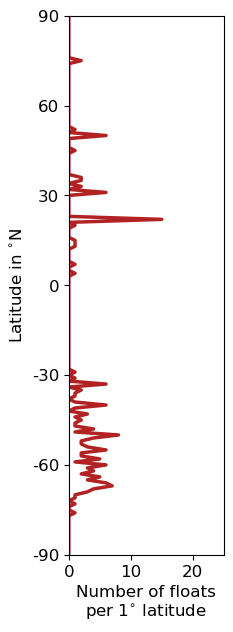

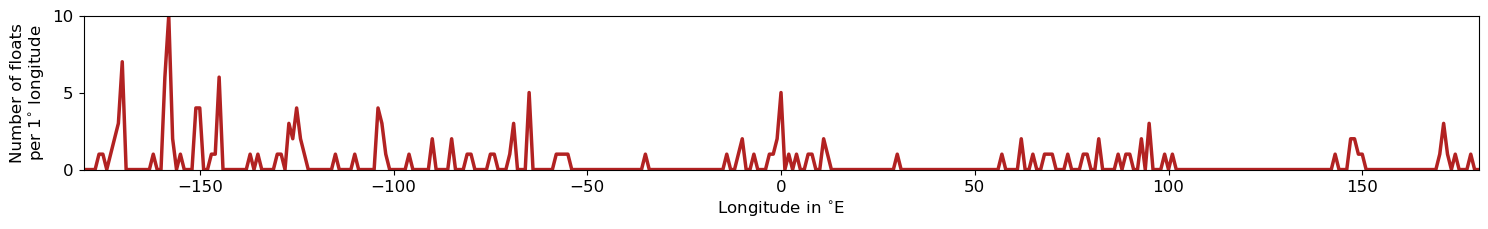

In [30]:

#---
# plot: num floats per latitude for SOCCOM
#---
lw = 2.5
fs = 12

color1 = 'firebrick'

fig = plt.figure(figsize=(2,7))
plt.plot(num_floats_per_lat_bin_SOCCOM,lat_bins,color=color1,linewidth=lw)
plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
plt.xlabel('Number of floats\nper 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((0,25))
plt.xticks([0,10,20],[0,10,20],fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],[-90,-60,-30,0,30,60,90],fontsize=fs)

#plt.fill_between(
#        x= num_floats_per_lat_bin_ARGO, 
#        y1= lat_bins, 
#        where= (0 <= num_floats_per_lat_bin_ARGO)&(num_floats_per_lat_bin_ARGO <= 250),
#        color= color1,
#        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Floats_per_latitude_initial_float_positions_SOCCOM_2012_2017.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
    
plt.show()


#---
# plot: num floats per longitude for SOCCOM
#---
lw = 2.5
fs = 12
color1='firebrick'

fig = plt.figure(figsize=(18,2))
plt.plot(lon_bins,num_floats_per_lon_bin_SOCCOM,color=color1,linewidth=lw)
plt.xlabel('Longitude in $^{\circ}$E',fontsize=fs)
plt.ylabel('Number of floats\nper 1$^{\circ}$ longitude',fontsize=fs)
plt.ylim((0,10))
plt.xlim((-180,180))
plt.xticks(fontsize=fs)
plt.yticks([0,5,10],[0,5,10],fontsize=fs)

#plt.fill_between(
#        x= lon_bins, 
#        y1= num_floats_per_lon_bin_ARGO, 
#        where= (-180 <= lon_bins)&(lon_bins <= 180),
#        color= color1,
#        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Floats_per_longitude_initial_float_positions_SOCCOM_2012_2017.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
    
plt.show()




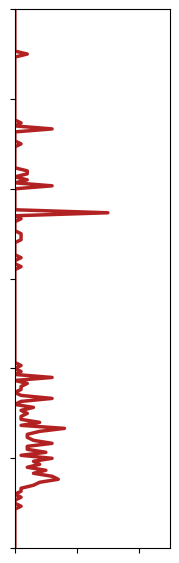

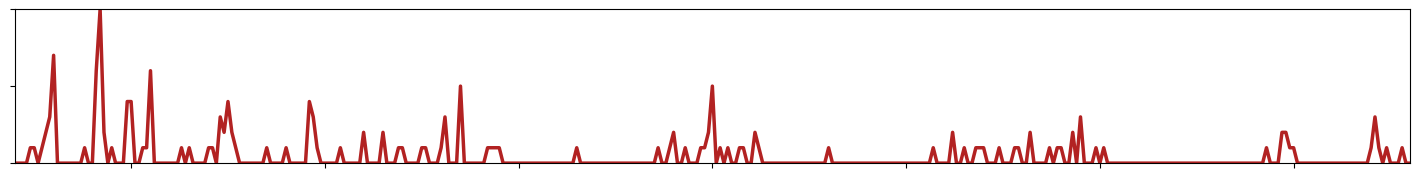

In [31]:
#---
# EPS
# plot: num floats per latitude for SOCCOM
#---
lw = 2.5
fs = 12

color1 = 'firebrick'

fig = plt.figure(figsize=(2,7))
plt.plot(num_floats_per_lat_bin_SOCCOM,lat_bins,color=color1,linewidth=lw)
#plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
#plt.xlabel('Number of floats\nper 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((0,25))
plt.xticks([0,10,20],[],fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],[],fontsize=fs)

#plt.fill_between(
#        x= num_floats_per_lat_bin_ARGO, 
#        y1= lat_bins, 
#        where= (0 <= num_floats_per_lat_bin_ARGO)&(num_floats_per_lat_bin_ARGO <= 250),
#        color= color1,
#        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Floats_per_latitude_initial_float_positions_SOCCOM_2012_2017.eps'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    
    
plt.show()


#---
# plot: num floats per longitude for SOCCOM
#---
lw = 2.5
fs = 12
color1='firebrick'

fig = plt.figure(figsize=(18,2))
plt.plot(lon_bins,num_floats_per_lon_bin_SOCCOM,color=color1,linewidth=lw)
#plt.xlabel('Longitude in $^{\circ}$E',fontsize=fs)
#plt.ylabel('Number of floats\nper 1$^{\circ}$ longitude',fontsize=fs)
plt.ylim((0,10))
plt.xlim((-180,180))
plt.xticks([-150,-100,-50,0,50,100,150],[],fontsize=fs)
plt.yticks([0,5,10],[],fontsize=fs)

#plt.fill_between(
#        x= lon_bins, 
#        y1= num_floats_per_lon_bin_ARGO, 
#        where= (-180 <= lon_bins)&(lon_bins <= 180),
#        color= color1,
#        alpha= 1)

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Floats_per_longitude_initial_float_positions_SOCCOM_2012_2017.eps'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    
    
plt.show()




In [ ]:
#---
# get resolution of mesh
#---
#print(area.shape)
#print(lat.shape,lon.shape)

# use the following relationship: Area of hexagon = (3*sqrt(3)*a2)/2, with a being the length of a side or the radius
# solve for "a" and multiply by 2 to get the resolution
res = np.sqrt((2/3)*area/np.sqrt(3))*2
print(res.shape,np.min(res),np.max(res))

#---
# Model resolution: get avg for each latitude
#---

print(len(lat_float))

lat_bins = np.arange(-90,90+1,1)

ind_bin = np.digitize(lat,lat_bins)
print(np.min(ind_bin),np.max(ind_bin))

avg_res_per_lat_bin = np.nan*np.ones(len(lat_bins))
for ii in range(0,len(lat_bins)):
    ind = np.where(ind_bin==ii+1)[0] # check if there should be a "+1" here or not
    if len(ind)>0:
        avg_res_per_lat_bin[ii] = np.sum(area[ind]*res[ind])/np.sum(area[ind])  #ind.shape[0]
    else:
        print('No grid cells for latitutde',ii,lat_bins[ii])
    del ind

print(np.nanmin(avg_res_per_lat_bin/1000),np.nanmax(avg_res_per_lat_bin/1000))

    
#---
# plot: avg resoluton per latitude 
#---
lw = 2.5
fs = 12

color1 = 'black'

fig = plt.figure(figsize=(2,7))
plt.plot(avg_res_per_lat_bin/1000,lat_bins,color=color1,linewidth=lw)
plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
plt.xlabel('Average model reoslution\nin km per 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((30,70))
plt.xticks([30,50,70],[30,50,70],fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],[-90,-60,-30,0,30,60,90],fontsize=fs)
plt.gca().invert_xaxis()

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Model_resolution_avg_per_latitude.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
    
plt.show()



#---
# EPS
# plot: avg resoluton per latitude 
#---
lw = 2.5
fs = 12

color1 = 'black'

fig = plt.figure(figsize=(2,7))
plt.plot(avg_res_per_lat_bin/1000,lat_bins,color=color1,linewidth=lw)
#plt.ylabel('Latitude in $^{\circ}$N',fontsize=fs)
#plt.xlabel('Average model reoslution\nin km per 1$^{\circ}$ latitude',fontsize=fs)
plt.ylim((-90,90))
plt.xlim((30,70))
plt.xticks([30,50,70],[],fontsize=fs)
plt.yticks([-90,-60,-30,0,30,60,90],[],fontsize=fs)
plt.gca().invert_xaxis()

save_plots = True
if save_plots:
    dpicnt = 200
    filename = 'Model_resolution_avg_per_latitude.eps'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)
    
    
plt.show()
